In [314]:
### Thesis is wrong on nhat unit vectors, see screenshot on phone (FP4). They look doable with LUTs

### Issue is whether matching of absolute r and thetas (to a common origin) kills performance gains


In [30]:
%matplotlib widget
from scipy.special import j0, j1
import numpy as np
import itertools as itrt
import matplotlib.pyplot as plt
%config Completer.use_jedi = False

In [2]:
def gamma_to_beta(gamma):
    return sqrt(1-1/gamma**2)
def kinetic_to_betagamma(energy, rest_energy):
    gamma = energy/rest_energy+1
    beta = gamma_to_beta(gamma)
    return beta, gamma

In [171]:
m = 1.007319468  #amu
c = 299.792458 # mm/ns
q = 1.178734E-5 ##1.6E-19 C => 4.8032047E-10 statC [cm^(3/2)*g^(1/2)*s^(-1)] => [mm^(3/2)*amu^(1/2)*ns^(-1)];
Px = np.random.normal(-3e-2, 3e-2, 200) #3e-2 amu*mm/ns corresponds to 93 keV
Py = np.random.uniform(-3e-2, 3e-2, 200)
Pz = np.random.uniform(3.4e2, 3.41e2, 200)  # approx 1 GeV +- 4 MeV, CAREFUL WE ARE IN LAB FRAME HERE
Pt = np.sqrt( Px**2+Py**2+Pz**2+m**2*c**2)
gamma = Pt/(m*c)
bx = Px/(gamma*m*c)
by = Py/(gamma*m*c)
bz = Pz/(gamma*m*c)
beta_avg  = np.sqrt(bx**2+by**2+bz**2)

x = numpy.random.normal(-50, 50, 200)
y = numpy.random.uniform(-50, 50, 200)
z = numpy.random.uniform(-50, 50, 200)
t = numpy.random.uniform(0, 100/(beta_avg*c), 200)

bdotx = bx*np.random.uniform(-1e-3,1e-3)  #just a guess, there is probably much more acceleration going on in the core
bdoty = by*np.random.uniform(-1e-3,1e-3) 
bdotz = bz*np.random.uniform(-1e-7,1e-7) #sloppy approximation to reflect much less deviation in logitudinal direction

In [172]:
init_beam = {'x':x, 'y':y, 'z':z, 't':t, 'Px':Px, 'Py':Py, 'Pz':Pz,'Pt':Pt,
             'bx':bx,'by':by,'bz':bz,'bdotx':bdotx,'bdoty':bdoty,'bdotz':bdotz,'gamma':gamma,'q':q} 

In [173]:
def dist_euclid(vector,vector_ext,index):    #this gives us 'nhat' for a single particle at 'index' with all other particles
    result = {}
    result['R'] = np.zeros_like(vector['x'])    
    result['nx'] = np.zeros_like(vector['x'])
    result['ny'] = np.zeros_like(vector['x'])    
    result['nz'] = np.zeros_like(vector['x'])    
    for i in range(len(vector['x'])):
        result['R'][i] = np.sqrt( (vector['x'][index]-vector_ext['x'][i])**2+
                          (vector['y'][index]-vector_ext['y'][i])**2+
                          (vector['z'][index]-vector_ext['z'][i])**2 )
        result['nx'][i] = (vector['x'][index]-vector_ext['x'][i])/result['R'][i]
        result['ny'][i] = (vector['y'][index]-vector_ext['y'][i])/result['R'][i]
        result['nz'][i] = (vector['z'][index]-vector_ext['z'][i])/result['R'][i]
    return(result)

In [174]:
def step1(h, vector,vector_ext): # nhat includes R and nhat components, need to generate this per particle pair
    for i in range(len(vector['x'])):   #iterating over particle pairs
        nhat = dist_euclid(vector,vector_ext,i)    
        result = {}
        result['x'] = vector['x']
        result['y'] = vector['y']
        result['z'] = vector['z']
        result['t'] = vector['t']
        result['Px'] = vector['Px'] + h/m*vector['q']*vector_ext['q']*vector['gamma']\
                    *1/(1-np.dot(vector_ext['bx','by','bz'],nhat['nx','ny','nz'])**2)\
                    *[ 1/nhat['R']**2*vector['bx']*np.dot(vector_ext['bx','by','bz'],vector('bx,by,bz'))\
                    -nhat['nx']*np.dot(vector_ext['bx','by','bz'],vector('bx,by,bz'))\
                    /(vector_ext['gamma']**2*nhat['R']**2*(1-np.dot(vector_ext['bx','by','bz'],nhat['nx','ny','nz'])))\
                    -nhat['nx']/(c*nhat['R'])*(np.dot(vector['bx','by','bz'],(vector_ext['bdotx','bdoty','bdotz']+vector_ext['gamma']**2\
                    *np.dot(vector_ext['bx','by','bz'],np.dot(vector_ext['bx','by','bz'],vector_ext['bdotx','bdoty','bdotz']) ) ) ) ) ]
        result['Py'] = vector['Py'] + h/m*vector['q']*vector_ext['q']*vector['gamma']\
                    *1/(1-np.dot(vector_ext['bx','by','bz'],nhat['nx','ny','nz'])**2)\
                    *[ 1/nhat['R']**2*vector['by']*np.dot(vector_ext['bx','by','bz'],vector('bx,by,bz'))\
                    -nhat['ny']*np.dot(vector_ext['bx','by','bz'],vector('bx,by,bz'))\
                    /(vector_ext['gamma']**2*nhat['R']**2*(1-np.dot(vector_ext['bx','by','bz'],nhat['nx','ny','nz'])))\
                    -nhat['ny']/(c*nhat['R'])*(np.dot(vector['bx','by','bz'],(vector_ext['bdotx','bdoty','bdotz']+vector_ext['gamma']**2\
                    *np.dot(vector_ext['bx','by','bz'],np.dot(vector_ext['bx','by','bz'],vector_ext['bdotx','bdoty','bdotz']) ) ) ) ) ]
        result['Pz'] = vector['Pz'] + h/m*vector['q']*vector_ext['q']*vector['gamma']\
                    *1/(1-np.dot(vector_ext['bx','by','bz'],nhat['nx','ny','nz'])**2)\
                    *[ 1/nhat['R']**2*vector['bz']*np.dot(vector_ext['bx','by','bz'],vector('bx,by,bz'))\
                    -nhat['nz']*np.dot(vector_ext['bx','by','bz'],vector('bx,by,bz'))\
                    /(vector_ext['gamma']**2*nhat['R']**2*(1-np.dot(vector_ext['bx','by','bz'],nhat['nx','ny','nz'])))\
                    -nhat['nz']/(c*nhat['R'])*(np.dot(vector['bx','by','bz'],(vector_ext['bdotx','bdoty','bdotz']+vector_ext['gamma']**2\
                    *np.dot(vector_ext['bx','by','bz'],np.dot(vector_ext['bx','by','bz'],vector_ext['bdotx','bdoty','bdotz']) ) ) ) ) ]
        result['Pt'] = vector['Pt'] + h/m*vector['q']*vector_ext['q']*vector['gamma'] \
                    *[((vector_ext['gamma']**2*np.dot(vector_ext['bx','by','bz'],vector_ext('bdotx,bdoty,bdotz')))/(cnhat['R']) \
                    - 1/nhat['R']**2) /(1 - np.dot(vector_ext['bx','by','bz'],nhat['nx','ny','nz']))]
        result['gamma'] = result['P0']/(m*c**2)
        result['bx'] = result['Px']/(m*c*result['gamma'])
        result['by'] = result['Py']/(m*c*result['gamma'])
        result['bz'] = result['Pz']/(m*c*result['gamma'])
        result['bdotx'] = (result['Px']-vector['Px']) / h   #necessary history to treat as an external particle later (keep in lab frame?) 
        result['bdoty'] =(result['Py']-vector['Py']) / h
        result['bdotz'] = (result['Pz']-vector['Pz']) / h
        vector = result #will this work? need to update values here between each particle pair calculation
    return result
        

def step2(h, vector,vector_ext,nhat): 
        result = {}
        result['x'] = vector['x'] + h/m * (vector['Px']+vector['q']/c*vector_ext['q']*vector_ext['bx']\
                    / (vector_ext['gamma']*c*nhat['R']*(1-np.dot(vector_ext['bx','by','bz'],nhat['nx','ny','nz']))))
        result['y'] = vector['y'] + h/m * (vector['Py']+vector['q']/c*vector_ext['q']*vector_ext['by']\
                    / (vector_ext['gamma']*c*nhat['R']*(1-np.dot(vector_ext['bx','by','bz'],nhat['nx','ny','nz']))))
        result['z'] = vector['z'] + h/m * (vector['Pz']+vector['q']/c*vector_ext['q']*vector_ext['bz']\
                    / (vector_ext['gamma']*c*nhat['R']*(1-np.dot(vector_ext['bx','by','bz'],nhat['nx','ny','nz']))))
        result['t'] = vector['t'] + h/m * (vector['Pt']+vector['q']/c*vector_ext['q']\
                    / (vector_ext['gamma']*c*nhat['R']*(1-np.dot(vector_ext['bx','by','bz'],nhat['nx','ny','nz']))))
        result['Px'] = vector['Px']
        result['Py'] = vector['Py']
        result['Pz'] = vector['Pz']
        result['Pt'] = vector['Pt']
        return result

In [175]:
beam = init_beam
external_particle = ?????
distances = ?????
for i in range(1,100):
    beam = step1(h, init_beam,external_particle,distances)
    beam = step2(h, init_beam,external_particle,distances)

SyntaxError: invalid syntax (2119329478.py, line 2)

##### Step 1 - Run the 'init_beam' as shown through some drift to thermalize, test on a FODO lattice if there is time to get a more realistic output distribution. This includes generating a 'distances' vector sampling from particle histories at appropriate previous timesteps, for all particle pairs in the bunch  (plenty of pairwise distance calculators we can use out of the box). Some bootstrapping needed (or advanced potentials) before there are particle histories. 
  <br>

##### Step 2 - Generate a second 'init_beam' for test points along the aperture surface. These will have zero starting momentum. Save momentum values for minimization in an optimization routine.  (LOW COST - ONCE PER INTEGRATION STEP)

  <br>

##### Step 3 - Generate spline map (or some simpler gradient map) along the aperture surface to determine local angles of reflection (ONLY NEEDED ONCE PER SIMULATION, NOT PER INTEGRATION STEP)

  <br>

##### Step 4 - Generate a 'distances' vector, for all particles pairs between the bunch and the reflected bunch (which is built using the spline map and has opposite-sign charge). (VERY COSTLY - ONCE PER INTEGRATION STEP)

  <br>


##### Step 4 - Identify surface points experiencing strongest force and minimize. Maximize longitudinal component of reflected force. (ONCE PER SIMULATION AT FIRST, THEN MAYBE FINE TUNE PER INTEGRATION STEP)

recall: ```init_beam = {'x':x, 'y':y, 'z':z, 't':t, 'Px':Px, 'Py':Py, 'Pz':Pz,'Pt':Pt,
            'bx':bx,'by':by,'bz':bz,'bdotx':bdotx,'bdoty':bdoty,'bdotz':bdotz,'gamma':gamma,'q':q} ```

In [176]:
def getspiral_params(b, vector): # the b is a spacing parameter, here in mm
    result = {}
    result['theta'] = np.sqrt( (vector['x']**2+vector['y']**2+vector['z']**2)/b**2)
    result['beta_theta'] = np.sqrt( (vector['bx']**2+vector['by']**2+vector['bz']**2)/b**2)
    return(result)  

In [180]:
def combs(a, r):
    """
    Return successive r-length combinations of elements in the array a.
    Should produce the same output as array(list(combinations(a, r))), but 
    faster. FROM: https://stackoverflow.com/questions/16003217/n-d-version-of-itertools-combinations-in-numpy
    """
    a = np.asarray(a)
    dt = dtype([('', a.dtype)]*r)
    b = np.fromiter(itrt.combinations(a, r), dt)
    return b.view(a.dtype).reshape(-1, r)

In [181]:
def spiral_distance_lookup_table(theta_range,epsilon,b): #epsilon generates azimuthal coordinates, must be IRRATIONAL
    result = {}
    result['theta_pairs'] = combs(theta_range,2)
    result['Rfact'] = empty(len(result['theta_pairs'][:,1]))
#     result['ntheta'] = empty(len(result['theta_pairs'][:,1]))
#     result['nphi'] = empty(len(result['theta_pairs'][:,1])) 
#     result['nr'] = empty(len(result['theta_pairs'][:,1])) 
    
    for i in range(len(result['theta_pairs'][:,1])):
        result['Rfact'][i] = np.sin(np.deg2rad(result['theta_pairs'][i,0]))*np.sin(np.deg2rad(result['theta_pairs'][i,1]))*\
        np.cos(np.deg2rad(epsilon*(result['theta_pairs'][i,0]-result['theta_pairs'][i,1])))
#         result['ntheta'][i] = (result['theta_pairs'][i,0]-result['theta_pairs'][i,1])/result['Rfact'][i]
#         result['nphi'][i] = epsilon*(result['theta_pairs'][i,0]-result['theta_pairs'][i,1])/result['Rfact'][i]
#         result['nr'][i] = b*(result['theta_pairs'][i,0]-result['theta_pairs'][i,1])/result['Rfact'][i]        
    return(result)

In [182]:
epsilon_value = 181.2 #generates azimuthal coordinates, must be IRRATIONAL factor greater than pi
theta_range_vector = np.arange(1,1000,1)
Rfact_table = spiral_distance_lookup_table(theta_range_vector,epsilon_value,1);

In [183]:
vector_spiral = getspiral_params(1,init_beam)

In [317]:
def spiral_distance(vector_spiral,vector_spiral_ext,Rfact_table,index):
    Rs = []
    ns = []
    theta_local = np.rint(vector_spiral['theta'][index])
    for j in range(0,len(vector_spiral_ext['theta'])):
        #if j!=index:
            theta_external = np.rint(vector_spiral_ext['theta'][j])
            Rfact_index =  np.where((Rfact_table['theta_pairs'][:,0] == theta_local) & (Rfact_table['theta_pairs'][:,1]==theta_external*2))[0]
            Rfact = Rfact_table['Rfact'][Rfact_index]
            #print(Rfact[0])
            
            d = np.sqrt(theta_local**2+theta_external**2-theta_local*theta_external*Rfact) #assumes 'b' = 1 , for speedup, but locks to  1 deg = 1 mm for now                
            #print(d)
            ntheta = (Rfact_table['theta_pairs'][Rfact_index,0]-Rfact_table['theta_pairs'][Rfact_index,1])/Rfact
            Rs.append(d) #change to numpy.append
            #print(Rs)
            ns.append(ntheta)
    return(Rs,ns)

In [318]:
Rfact_table['theta_pairs']

array([[  1,   2],
       [  1,   3],
       [  1,   4],
       ...,
       [997, 998],
       [997, 999],
       [998, 999]])

In [319]:
%timeit Rs,ns =spiral_distance(vector_spiral,vector_spiral,Rfact_table,3);

200 ms ± 10.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [291]:
len(Rs)

200

In [298]:
bob=()

In [210]:
def bunch_distances(vector_spiral,vector_spiral_ext):
    R_full =[]
    n_full=[] 
    for i in range(1,len(vector_spiral['theta'])):
        Rvals, nvals = spiral_distance(vector_spiral,vector_spiral_ext,Rfact_table,i)
        R_full.append(Rvals)
        n_full.append(nvals)
    return(R_full,n_full)

In [187]:
%time R_bunch, n_bunch = bunch_distances(vector_spiral,vector_spiral)

CPU times: user 39.5 s, sys: 71 ms, total: 39.6 s
Wall time: 39.7 s


In [211]:
R_bunch.shape()

AttributeError: 'list' object has no attribute 'shape'

In [138]:
Rvals

[array([201.12530151]),
 array([80.35438681]),
 array([81.10997593]),
 array([114.67280627]),
 array([139.27325977]),
 array([121.57877632]),
 array([96.5732099]),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([126.16863568]),
 array([98.19486678]),
 array([127.9706385]),
 array([114.07212006]),
 array([], dtype=float64),
 array([78.70879413]),
 array([126.65028499]),
 array([78.70879413]),
 array([85.10111096]),
 array([103.12360713]),
 array([90.40073287]),
 array([121.48012599]),
 array([119.18809664]),
 array([125.78697751]),
 array([114.83192879]),
 array([127.99474224]),
 array([80.35438681]),
 array([127.066731]),
 array([], dtype=float64),
 array([118.11822356]),
 array([106.38777093]),
 array([93.40839788]),
 array([106.38777093]),
 array([118.01670822]),
 array([114.07212006]),
 array([98.19486678]),
 array([126.87070262]),
 array([], dtype=float64),
 array([101.47768298]),
 array([116.31787959]),
 array([79

In [60]:
nvals

[array([-9136.49561372]),
 array([-4.72437049e+17]),
 array([], dtype=float64),
 array([], dtype=float64),
 array([7128.01691792]),
 array([-1703.14778331]),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([858.507535]),
 array([], dtype=float64),
 array([1133.90116171]),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([850.22916366]),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([1072.42674237]),
 array([1280.7705978]),
 array([], dtype=float64),
 array([3161.71161046]),
 array([933.40489734]),
 array([], dtype=float64),
 array([847.88741598]),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([-5534.46192813]),
 array([], dtype=float64),
 array([], dtype=float64),
 a

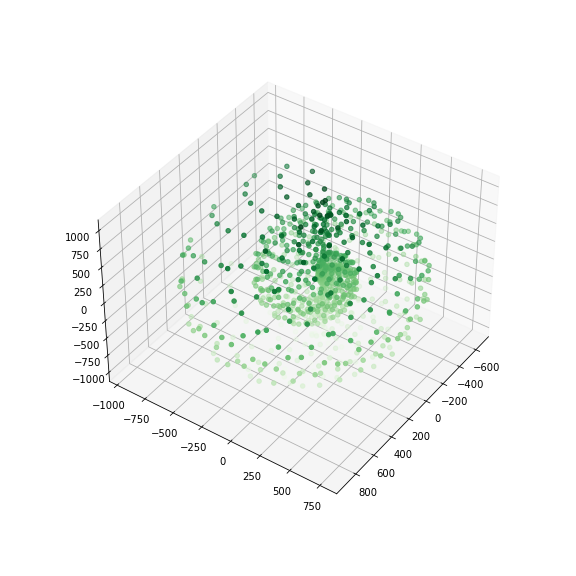

In [32]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
#ax = plt.axes(projection='3d')

# # Data for a three-dimensional line
# zline = np.linspace(0, 15, 1000)
# xline = np.sin(zline)
# yline = np.cos(zline)
# ax.plot3D(xline, yline, zline, 'gray')

# # Data for three-dimensional scattered points
zdata = theta_range_vector*np.cos(theta_range_vector)
xdata = theta_range_vector*np.sin(theta_range_vector)*np.cos(theta_range_vector*epsilon_value)
ydata = theta_range_vector*np.sin(theta_range_vector)*np.sin(theta_range_vector*epsilon_value)

ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens');
ax.view_init(40, 35)

In [ ]:
plt.hist(result, bins = 200)
plt.show()